# Project 4: Predict West Nile Virus
### Section 3. Weather Data Cleaning & EDA

## Problem Statement

1. As an employee of Disease And Treatment Agency, division of Societal Cures In Epidemiology and New Creative Engineering (DATA-SCIENCE), we are tasked to better understand the mosquito population and advise on appropriate interventions which are beneficial and cost-effective for the city.


2. Through this project, we hope to:
- Identify features which are most important to predict presence of West Nile Virus (which can be done by ranking the coefficients of each feature in a logistic regression model)
- Predict the probability of West Nile Virus by location to provide decision makers an effective plan to deploy pesticides throughout the city, which consequently can help to reduce cost.

## Import Libraries

In [1]:
#!pip install shapely
#!pip install descartes

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely import geometry
from shapely.geometry import Point, Polygon
import geopandas as gpd
from datetime import timedelta
import math

In [2]:
# Set chart style
plt.style.use('fivethirtyeight')

## Load Data

In [3]:
# Load datasets
weather = pd.read_csv('../data/data_weather.csv', index_col='Unnamed: 0')
traintest = pd.read_csv('../data/processed_traintest.csv', index_col='Unnamed: 0')
spray = pd.read_csv('../data/processed_spray.csv', index_col='Unnamed: 0')

In [4]:
# Convert date column to datetime type 
traintest['date'] = pd.to_datetime(traintest['date'])
weather['date'] = pd.to_datetime(weather['date'])
spray['date'] = pd.to_datetime(spray['date'])

## Cleaning and EDA of Weather Data

### Tmax, Tmin, Tavg

In [5]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2944 entries, 0 to 2943
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station      2944 non-null   int64         
 1   date         2944 non-null   datetime64[ns]
 2   tmax         2944 non-null   int64         
 3   tmin         2944 non-null   int64         
 4   tavg         2944 non-null   object        
 5   depart       2944 non-null   object        
 6   dewpoint     2944 non-null   int64         
 7   wetbulb      2944 non-null   object        
 8   heat         2944 non-null   object        
 9   cool         2944 non-null   object        
 10  sunrise      2944 non-null   object        
 11  sunset       2944 non-null   object        
 12  codesum      2944 non-null   object        
 13  depth        2944 non-null   object        
 14  water1       2944 non-null   object        
 15  snowfall     2944 non-null   object        
 16  precip

There are 11 'M' values, which are missing values, in Tavg. As Tavg is approximately the average of Tmax and Tmin, based on the other data points, we impute these missing values with the average.

In [6]:
# create a function to impute missing Tavg with the average of Tmax and Tmin
def impute_missing_tavg(row):
    if row['tavg'] == 'M': 
        row['tavg'] = (row['tmax'] + row['tmin']) * 0.5 
    return row

In [7]:
weather = weather.apply(impute_missing_tavg, axis = 1)
weather.tavg = weather.tavg.astype('int64')

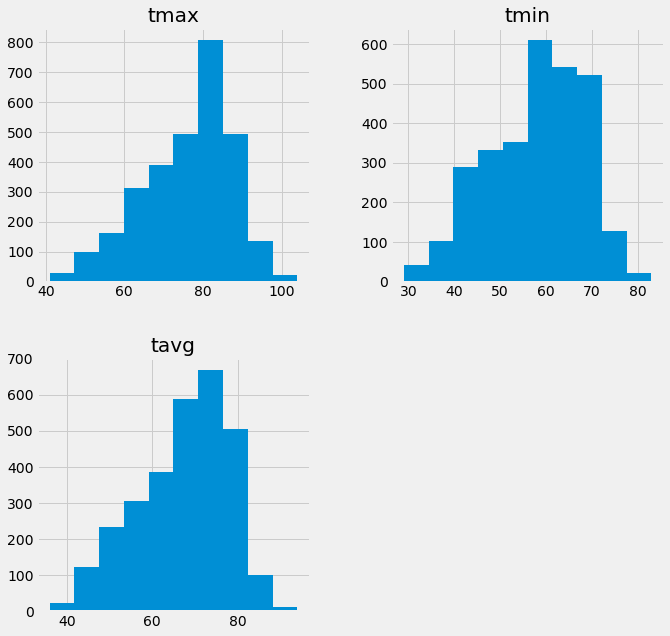

In [8]:
# Look at the distribution of these features
weather[['tmax', 'tmin', 'tavg']].hist(figsize=(10, 10));

In [9]:
weather[['tmax', 'tmin', 'tavg']].describe()

,tmax,tmin,tavg
count,2944.000000,2944.000000,2944.000000
mean,76.166101,57.810462,67.238111
std,11.461970,10.381939,10.538702
min,41.000000,29.000000,36.000000
25%,69.000000,50.000000,60.000000
50%,78.000000,59.000000,69.000000
75%,85.000000,66.000000,75.000000
max,104.000000,83.000000,94.000000


In [10]:
weather[['tmax', 'tmin', 'tavg']].value_counts().idxmax()

(79, 60, 70)

All the temperatures recordings seem to be left-skewed, with the peaks centering around 76,60 and 70 degrees farenheit respectively for tmax, tmin and tavg.

### Sunrise and Sunset

We saw that we cannot plot the data because there seems to be non-integer values.

We observe that each day has two sets of weather data, recorded by station 1 and station 2 respectively. Station 2's sunrise and sunset data are missing and labelled as 'M'.

As they are arranged by day, when they are separated and aligned side-by-side, and knowing that sunrise and sunset should be the same for data stations since they are situated relatively close to one another, we can equate station 1's sunrise and sunset data to station 2's missing data.

In [11]:
station1 = weather[weather['station']==1].copy()
station2 = weather[weather['station']==2].copy()

In [12]:
station1.reset_index(inplace=True)

In [13]:
station2.reset_index(inplace=True)

In [14]:
station2["sunrise"].head()

0    -
1    -
2    -
3    -
4    -
Name: sunrise, dtype: object

In [15]:
station2["sunrise"]= station1["sunrise"]

In [16]:
station2["sunset"]= station1["sunset"]

In [17]:
weather = pd.concat([station1,station2],axis=0)

In [18]:
weather.reset_index().head()

,level_0,index,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
0,0,0,1,2007-05-01,83,50,67,14,51,56,...,0.00,29.10,29.82,1.7,27,9.2,2007,5,18,1
1,1,2,1,2007-05-02,59,42,51,-3,42,47,...,0.00,29.38,30.09,13.0,4,13.4,2007,5,18,2
2,2,4,1,2007-05-03,66,46,56,2,40,48,...,0.00,29.39,30.12,11.7,7,11.9,2007,5,18,3
3,3,6,1,2007-05-04,66,49,58,4,41,50,...,T,29.31,30.05,10.4,8,10.8,2007,5,18,4
4,4,8,1,2007-05-05,66,53,60,5,38,49,...,T,29.40,30.10,11.7,7,12.0,2007,5,18,5


In [19]:
weather.drop(columns=["index"],inplace = True)

In [20]:
weather.sunrise= weather.sunrise.astype('int64')

In [21]:
weather.sunset= weather.sunset.astype('int64')

We also found that for sunset, there are some values that have 60 minutes, instead of adding to the hour. We will write a function to add an hour and remove that 60 minutes.

In [22]:
count = 0
for i in weather['sunrise']: 
    i = str(i)
    for a in range(60,99):
        if i[2:] == str(a):
            print(i)

In [23]:
count = 0
for i in weather['sunset']: 
    i = str(i)
    for a in range(60,99):
        if i[2:] == str(a):
            print(i)

1860
1760
1660
1860
1760
1660
1860
1760
1660
1860
1760
1660
1860
1760
1660
1860
1760
1660
1860
1760
1660
1860
1760
1660
1860
1760
1660
1860
1760
1660
1860
1760
1660
1860
1760
1660
1860
1760
1660
1860
1760
1660
1860
1760
1660
1860
1760
1660


In [24]:
for index,row in weather.iterrows():
    
    sunset = int(row['sunset'])
    sunset = str(sunset)
    
    if sunset[-2:] == '60':
        
        hour = int(sunset[:2])
        mins = int(sunset[-2:])
        
        mins = '00'
        hour += 1
        hour = str(hour)
        
        weather.at[index,'sunset'] = hour + mins  

In [25]:
weather.sunset= weather.sunset.astype('int64')

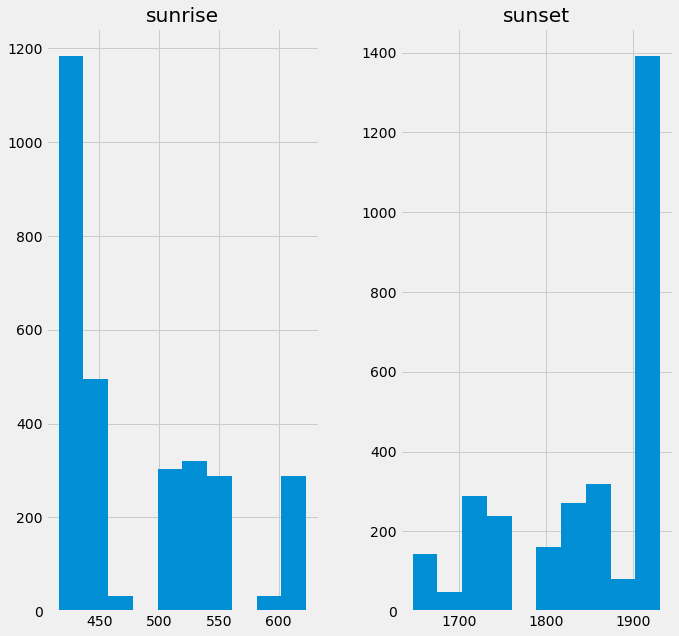

In [26]:
weather[['sunrise', 'sunset']].hist(figsize=(10, 10));

### Depart

(array([ 335.,  177.,  149.,  239.,  210.,  264.,   27.,   31.,   28.,
        1484.]),
 array([ 0. ,  4.1,  8.2, 12.3, 16.4, 20.5, 24.6, 28.7, 32.8, 36.9, 41. ]),
 <BarContainer object of 10 artists>)

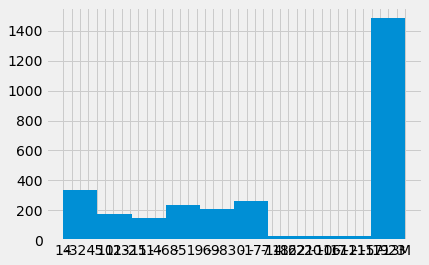

In [27]:
plt.hist(weather['depart'])

In [28]:
weather['depart'].value_counts();

In [29]:
weather.tail(6)

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
1466,2,2014-10-26,66,44,55,M,33,45,10,0,...,0.00,29.28,29.95,1.6,11,5.4,2014,10,43,6
1467,2,2014-10-27,79,54,67,M,52,59,0,2,...,0.02,29.00,29.67,12.7,19,13.6,2014,10,44,0
1468,2,2014-10-28,66,48,57,M,40,48,8,0,...,0.03,29.23,29.85,14.0,26,14.6,2014,10,44,1
1469,2,2014-10-29,49,40,45,M,34,42,20,0,...,0.00,29.42,30.07,8.5,29,9.0,2014,10,44,2
1470,2,2014-10-30,53,37,45,M,35,42,20,0,...,T,29.41,30.10,5.9,23,6.5,2014,10,44,3
1471,2,2014-10-31,49,34,42,M,29,36,23,0,...,0.04,29.54,30.20,21.7,34,22.6,2014,10,44,4


There are 1472 missing values from "depart" and they are from station 2. "Depart" refers to the how much the dekadal (10-day) average temperatures is above or below the 30-year normal. 

Though there is no column for the dekadal average temperature, we can get the dekadal average temperature of any day from the "Depart" and tavg in Station 1. We can then calculate "Depart" for Station 2 as we have tavg for Station 2.

In [30]:
station1 = weather[weather['station']==1].copy()
station2 = weather[weather['station']==2].copy()

In [31]:
station1.reset_index(inplace=True)

In [32]:
station2.reset_index(inplace=True)

In [33]:
station1.depart= station1.depart.astype('int64')

In [34]:
station2["depart"] = station2["tavg"] - (station1["tavg"]- station1["depart"]) 

In [35]:
station2["depart"]

0       15
1       -2
2        4
3       10
4        5
        ..
1467    19
1468    10
1469    -2
1470    -1
1471    -4
Name: depart, Length: 1472, dtype: int64

In [36]:
weather = pd.concat([station1,station2],axis=0)
weather.reset_index().head()
weather.drop(columns=["index"],inplace = True)

In [37]:
weather.tail(3)

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
1469,2,2014-10-29,49,40,45,-2,34,42,20,0,...,0.00,29.42,30.07,8.5,29,9.0,2014,10,44,2
1470,2,2014-10-30,53,37,45,-1,35,42,20,0,...,T,29.41,30.10,5.9,23,6.5,2014,10,44,3
1471,2,2014-10-31,49,34,42,-4,29,36,23,0,...,0.04,29.54,30.20,21.7,34,22.6,2014,10,44,4


### Codesum

(array([2410.,  142.,  163.,  113.,   47.,   21.,   14.,   14.,   10.,
          10.]),
 array([ 0. ,  9.7, 19.4, 29.1, 38.8, 48.5, 58.2, 67.9, 77.6, 87.3, 97. ]),
 <BarContainer object of 10 artists>)

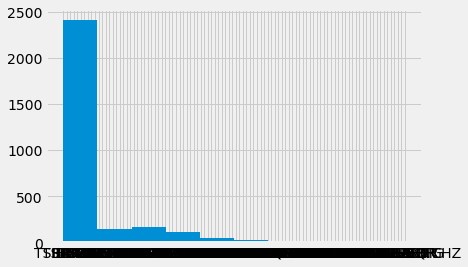

In [38]:
plt.hist(weather['codesum'])

In [39]:
weather['codesum'].describe()

count     2944
unique      98
top           
freq      1609
Name: codesum, dtype: object

In [40]:
weather['codesum'].value_counts()

                 1609
RA                296
RA BR             238
BR                110
TSRA RA BR         92
                 ... 
TS RA BR HZ         1
BCFG BR             1
RA BR HZ VCTS       1
TSRA RA HZ FU       1
RA SN BR            1
Name: codesum, Length: 98, dtype: int64

### Dewpoint

(array([ 26.,  89., 146., 308., 323., 459., 624., 467., 393., 109.]),
 array([22. , 27.3, 32.6, 37.9, 43.2, 48.5, 53.8, 59.1, 64.4, 69.7, 75. ]),
 <BarContainer object of 10 artists>)

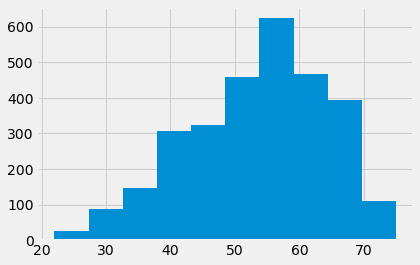

In [41]:
plt.hist(weather['dewpoint'])

In [42]:
weather['dewpoint'].describe()

count    2944.000000
mean       53.457880
std        10.675181
min        22.000000
25%        46.000000
50%        54.000000
75%        62.000000
max        75.000000
Name: dewpoint, dtype: float64

### Wetbulb

(array([312., 492., 409., 384., 549., 426., 189., 108.,  32.,  43.]),
 array([ 0. ,  4.7,  9.4, 14.1, 18.8, 23.5, 28.2, 32.9, 37.6, 42.3, 47. ]),
 <BarContainer object of 10 artists>)

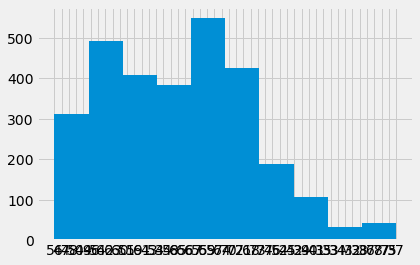

In [43]:
plt.hist(weather['wetbulb'])

In [44]:
weather['wetbulb'].describe()

count     2944
unique      48
top         63
freq       135
Name: wetbulb, dtype: object

In [45]:
weather['wetbulb'].value_counts();

In [46]:
weather[weather['wetbulb'] =="M"]

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
424,1,2009-06-26,86,69,78,7,60,M,0,13,...,0.00,M,29.85,6.4,4,8.2,2009,6,26,4
1205,1,2013-08-10,81,64,73,0,57,M,0,8,...,0.00,M,30.08,5.3,5,6.5,2013,8,32,5
1206,1,2013-08-11,81,60,71,-2,61,M,0,6,...,0.01,29.35,30.07,2.0,27,3.0,2013,8,32,6
1207,2,2013-08-12,85,69,77,4,63,M,0,12,...,0.66,29.27,29.92,4.5,26,7.7,2013,8,33,0


In [47]:
weather[weather['date'] == "2009-06-26"]


,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
424,1,2009-06-26,86,69,78,7,60,M,0,13,...,0.00,M,29.85,6.4,4,8.2,2009,6,26,4
424,2,2009-06-26,86,72,79,8,61,67,0,14,...,0.00,29.20,29.83,6.4,4,8.0,2009,6,26,4


In [48]:
weather.iloc[424,7] = 67

In [49]:
weather[weather['date'] == "2013-08-10"]


,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
1205,1,2013-08-10,81,64,73,0,57,M,0,8,...,0.00,M,30.08,5.3,5,6.5,2013,8,32,5
1205,2,2013-08-10,81,68,75,2,55,63,0,10,...,0.00,M,30.07,6.0,6,7.4,2013,8,32,5


In [50]:
weather.iloc[1205,7] = 63

In [51]:
weather[weather['date'] == "2013-08-11"]


,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
1206,1,2013-08-11,81,60,71,-2,61,M,0,6,...,0.01,29.35,30.07,2.0,27,3.0,2013,8,32,6
1206,2,2013-08-11,84,63,74,1,57,64,0,9,...,T,29.42,30.06,4.0,24,5.4,2013,8,32,6


In [52]:
weather.iloc[1206,7] = 64

In [53]:
weather[weather['date'] == "2013-08-12"]


,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
1207,1,2013-08-12,82,67,75,2,65,68,0,10,...,0.27,29.21,29.93,3.5,27,7.5,2013,8,33,0
1207,2,2013-08-12,85,69,77,4,63,M,0,12,...,0.66,29.27,29.92,4.5,26,7.7,2013,8,33,0


In [54]:
weather.iloc[2679,7] = 68

In [55]:
weather.wetbulb = weather.wetbulb.astype('int64')

### Heat and Cool

In [56]:
weather['heat'].describe()

count     2944
unique      31
top          0
freq      1870
Name: heat, dtype: object

In [57]:
weather['cool'].describe()

count     2944
unique      31
top          0
freq      1147
Name: cool, dtype: object

In [58]:
weather['heat'].value_counts()

0     1870
4       88
1       86
2       81
8       67
3       66
5       61
15      57
12      49
7       49
10      48
11      48
9       46
13      46
6       45
14      36
16      29
20      28
18      24
19      24
21      19
17      17
23      15
22      12
M       11
24       7
25       5
26       4
27       2
28       2
29       2
Name: heat, dtype: int64

In [59]:
weather['cool'].value_counts()

 0    1147
 8     138
 5     117
12     117
10     110
 6     109
 9     107
 7     104
 4     103
13     102
11     100
 3      99
14      98
 1      93
 2      89
15      84
16      55
17      48
18      34
19      21
20      16
21      16
M       11
22       9
23       4
26       4
24       4
25       2
28       1
27       1
29       1
Name: cool, dtype: int64

There are 11 'M' values each for both 'heat' and 'cool' columns.

In [60]:
weather.head(10)

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,0.00,29.10,29.82,1.7,27,9.2,2007,5,18,1
1,1,2007-05-02,59,42,51,-3,42,47,14,0,...,0.00,29.38,30.09,13.0,4,13.4,2007,5,18,2
2,1,2007-05-03,66,46,56,2,40,48,9,0,...,0.00,29.39,30.12,11.7,7,11.9,2007,5,18,3
3,1,2007-05-04,66,49,58,4,41,50,7,0,...,T,29.31,30.05,10.4,8,10.8,2007,5,18,4
4,1,2007-05-05,66,53,60,5,38,49,5,0,...,T,29.40,30.10,11.7,7,12.0,2007,5,18,5
5,1,2007-05-06,68,49,59,4,30,46,6,0,...,0.00,29.57,30.29,14.4,11,15.0,2007,5,18,6
6,1,2007-05-07,83,47,65,10,41,54,0,0,...,T,29.38,30.12,8.6,18,10.5,2007,5,19,0
7,1,2007-05-08,82,54,68,12,58,62,0,3,...,0.00,29.29,30.03,2.7,11,5.8,2007,5,19,1
8,1,2007-05-09,77,61,69,13,59,63,0,4,...,0.13,29.21,29.94,3.9,9,6.2,2007,5,19,2
9,1,2007-05-10,84,56,70,14,52,60,0,5,...,0.00,29.20,29.92,0.7,17,4.1,2007,5,19,3


It appears that "heat" only has a value when it tavg is below 65, and takes on a value of 65-tavg, while "cool" has a value when tavg is above 65, and takes on a value of tavg-65. On the documentation this reads as "Heating" and "Cooling", which might refer to the "heating and cooling effect required".

In [61]:
def impute_missing_heat_cool(row): 
    if row['heat'] == 'M':
        if row['tavg'] < 65: 
            row['heat'] = 65 - row['tavg']
            row['cool'] = 0
        else: 
            row['heat'] = 0
            row['cool'] = row['tavg'] - 65
    return row

In [62]:
weather = weather.apply(impute_missing_heat_cool, axis = 1)

In [63]:
weather.head()

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,0.00,29.10,29.82,1.7,27,9.2,2007,5,18,1
1,1,2007-05-02,59,42,51,-3,42,47,14,0,...,0.00,29.38,30.09,13.0,4,13.4,2007,5,18,2
2,1,2007-05-03,66,46,56,2,40,48,9,0,...,0.00,29.39,30.12,11.7,7,11.9,2007,5,18,3
3,1,2007-05-04,66,49,58,4,41,50,7,0,...,T,29.31,30.05,10.4,8,10.8,2007,5,18,4
4,1,2007-05-05,66,53,60,5,38,49,5,0,...,T,29.40,30.10,11.7,7,12.0,2007,5,18,5


In [64]:
weather[weather['heat']=="M"]

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek


In [65]:
weather['cool'].describe()

count     2944
unique      37
top          0
freq      1147
Name: cool, dtype: object

In [66]:
weather.heat = weather.heat.astype('int64')

In [67]:
weather.cool = weather.cool.astype('int64')

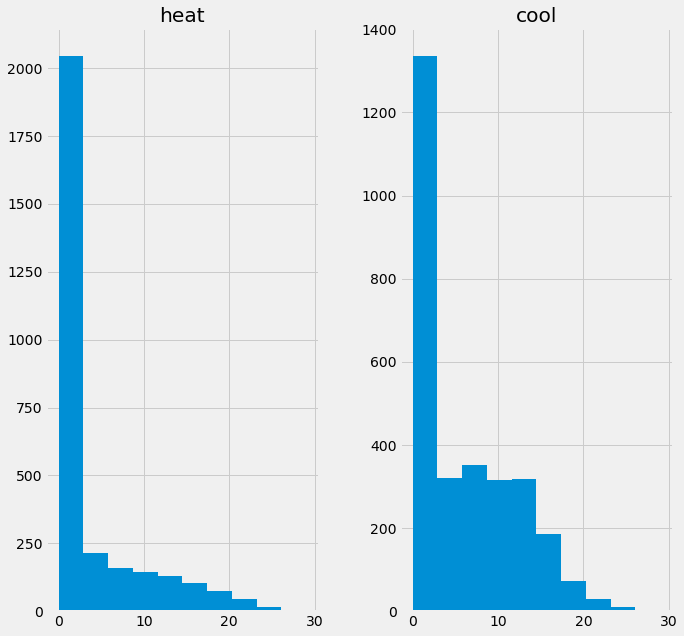

In [68]:
weather[['heat', 'cool']].hist(figsize=(10, 10));

### Depth

(array([1472.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1472.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

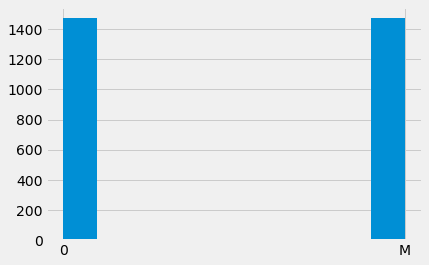

In [69]:
plt.hist(weather['depth'])

In [70]:
weather['depth'].describe()

count     2944
unique       2
top          0
freq      1472
Name: depth, dtype: object

In [71]:
weather['depth'] = 0

There are no differentiating factors for Depth. We will therefore drop it.

In [72]:
weather.drop(columns = ['depth'],inplace = True)

### Water 1

(array([   0.,    0.,    0.,    0.,    0., 2944.,    0.,    0.,    0.,
           0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

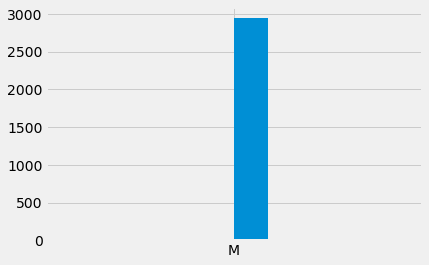

In [73]:
plt.hist(weather['water1'])

In [74]:
weather['water1'].describe()

count     2944
unique       1
top          M
freq      2944
Name: water1, dtype: object

We will therefore drop water 1 as all are missing values.

In [75]:
weather.drop(columns = ['water1'],inplace = True)

### SnowFall

(array([1.459e+03, 0.000e+00, 0.000e+00, 1.200e+01, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.472e+03]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

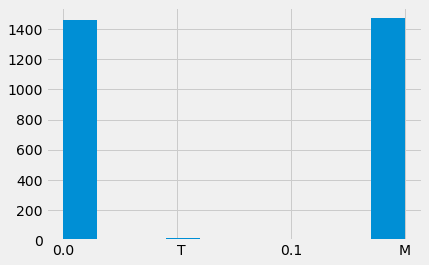

In [76]:
plt.hist(weather['snowfall'])

In [77]:
weather['snowfall'].value_counts()

M      1472
0.0    1459
  T      12
0.1       1
Name: snowfall, dtype: int64

In [78]:
weather[["date","station","snowfall"]].head(20)

,date,station,snowfall
0,2007-05-01,1,0.0
1,2007-05-02,1,0.0
2,2007-05-03,1,0.0
3,2007-05-04,1,0.0
4,2007-05-05,1,0.0
5,2007-05-06,1,0.0
6,2007-05-07,1,0.0
7,2007-05-08,1,0.0
8,2007-05-09,1,0.0
9,2007-05-10,1,0.0


In [79]:
station1 = weather[weather['station']==1].copy()
station2 = weather[weather['station']==2].copy()
station1.reset_index(inplace=True)
station2.reset_index(inplace=True)

In [80]:
station2["snowfall"]= station1["snowfall"]

In [81]:
weather = pd.concat([station1,station2],axis=0)
weather.reset_index().head()
weather.drop(columns=["index"],inplace = True)

In [82]:
weather["snowfall"] = weather["snowfall"].str.replace(" T","0.0")

In [83]:
weather.snowfall = weather.snowfall.astype('float')

There are almost no differentiating values for snowfall. We will drop this column. 

In [84]:
weather.drop(columns=["snowfall"],inplace = True)

### PrecipTotal

(array([2281.,  217.,  135.,   55.,   81.,   56.,   42.,   35.,   22.,
          20.]),
 array([  0. ,  16.7,  33.4,  50.1,  66.8,  83.5, 100.2, 116.9, 133.6,
        150.3, 167. ]),
 <BarContainer object of 10 artists>)

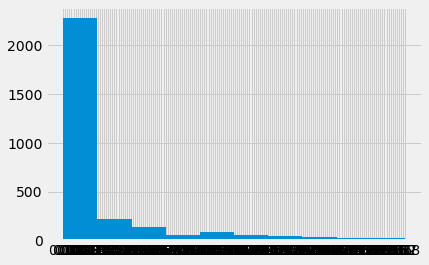

In [85]:
plt.hist(weather['preciptotal'])

In [86]:
weather['preciptotal'].describe()

count     2944
unique     168
top       0.00
freq      1577
Name: preciptotal, dtype: object

In [87]:
weather['preciptotal'].value_counts()

0.00    1577
  T      318
0.01     127
0.02      63
0.03      46
        ... 
1.24       1
1.96       1
1.46       1
1.88       1
1.18       1
Name: preciptotal, Length: 168, dtype: int64

In [88]:
count = 0
for i in weather['preciptotal']:
    if i == "M":
        count += 1
print(count)

2


In [89]:
weather[weather['preciptotal'] =="M"]

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
58,2,2007-06-28,73,61,67,-4,56,61,0,2,...,M,29.43,30.07,12.2,2,13.3,2007,6,26,3
59,2,2007-06-29,71,56,64,-7,56,60,1,0,...,M,29.47,30.11,7.4,2,8.2,2007,6,26,4


In [90]:
weather[weather['date'] =="2007-06-28"]

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
58,1,2007-06-28,74,58,66,-5,55,60,0,1,...,0.00,29.41,30.09,11.9,3,12.5,2007,6,26,3
58,2,2007-06-28,73,61,67,-4,56,61,0,2,...,M,29.43,30.07,12.2,2,13.3,2007,6,26,3


In [91]:
weather[weather['date'] =="2007-06-29"]

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
59,1,2007-06-29,70,56,63,-8,55,59,2,0,...,0.00,29.41,30.13,7.6,2,8.3,2007,6,26,4
59,2,2007-06-29,71,56,64,-7,56,60,1,0,...,M,29.47,30.11,7.4,2,8.2,2007,6,26,4


We will adjust the precip total down to 0 since that was recorded in the ther weather station for these two dates.

In [92]:
def impute_missing_precip(row): 
    if row['preciptotal'] == 'M':
        row['preciptotal'] = 0.00
    return row

In [93]:
weather = weather.apply(impute_missing_precip, axis = 1)

In [94]:
weather[weather['preciptotal'] =="M"]

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek


In [95]:
count = 0
for i in weather['preciptotal']:
    if i == "T":
        count += 1
print(count)

0


In [96]:
weather["preciptotal"] = weather["preciptotal"].str.replace(" T","0.00")

In [97]:
weather["preciptotal"].isnull().sum()

2

In [98]:
weather[weather["preciptotal"].isnull()]

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
58,2,2007-06-28,73,61,67,-4,56,61,0,2,...,NaN,29.43,30.07,12.2,2,13.3,2007,6,26,3
59,2,2007-06-29,71,56,64,-7,56,60,1,0,...,NaN,29.47,30.11,7.4,2,8.2,2007,6,26,4


In [99]:
weather.reset_index(inplace = True)

In [100]:
weather[weather['date'] =="2007-06-28"]

,index,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
58,58,1,2007-06-28,74,58,66,-5,55,60,0,...,0.00,29.41,30.09,11.9,3,12.5,2007,6,26,3
1530,58,2,2007-06-28,73,61,67,-4,56,61,0,...,NaN,29.43,30.07,12.2,2,13.3,2007,6,26,3


In [101]:
weather[weather['date'] =="2007-06-29"]

,index,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
59,59,1,2007-06-29,70,56,63,-8,55,59,2,...,0.00,29.41,30.13,7.6,2,8.3,2007,6,26,4
1531,59,2,2007-06-29,71,56,64,-7,56,60,1,...,NaN,29.47,30.11,7.4,2,8.2,2007,6,26,4


In [102]:
weather.iloc[1530,-10] = 0.00

In [103]:
weather.iloc[1531,-10] = 0.00

### StnPressure

(array([749., 677., 422., 432., 254.,  64., 178., 112.,  33.,  23.]),
 array([  0. ,  10.3,  20.6,  30.9,  41.2,  51.5,  61.8,  72.1,  82.4,
         92.7, 103. ]),
 <BarContainer object of 10 artists>)

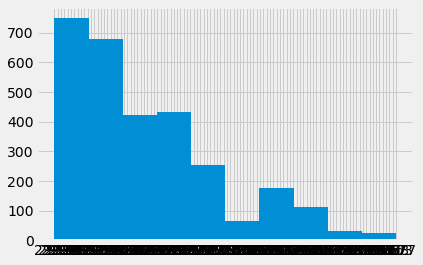

In [104]:
plt.hist(weather['stnpressure'])

In [105]:
weather['stnpressure'].describe()

count      2944
unique      104
top       29.34
freq        128
Name: stnpressure, dtype: object

In [106]:
count = 0
for i in weather['stnpressure']:
    if i == "M":
        count += 1
print(count)

4


In [107]:
weather[weather['stnpressure'] =="M"]

,index,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
424,424,1,2009-06-26,86,69,78,7,60,67,0,...,0.00,M,29.85,6.4,4,8.2,2009,6,26,4
1205,1205,1,2013-08-10,81,64,73,0,57,63,0,...,0.00,M,30.08,5.3,5,6.5,2013,8,32,5
1515,43,2,2007-06-13,86,68,77,9,53,62,0,...,0.00,M,M,7.0,5,M,2007,6,24,2
2677,1205,2,2013-08-10,81,68,75,2,55,63,0,...,0.00,M,30.07,6.0,6,7.4,2013,8,32,5


In [108]:
weather[weather['date'] =="2009-06-26"]

,index,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
424,424,1,2009-06-26,86,69,78,7,60,67,0,...,0.00,M,29.85,6.4,4,8.2,2009,6,26,4
1896,424,2,2009-06-26,86,72,79,8,61,67,0,...,0.00,29.20,29.83,6.4,4,8.0,2009,6,26,4


In [109]:
weather.iloc[424,-9] = 29.20

In [110]:
weather[weather['date'] =="2013-08-10"]

,index,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
1205,1205,1,2013-08-10,81,64,73,0,57,63,0,...,0.00,M,30.08,5.3,5,6.5,2013,8,32,5
2677,1205,2,2013-08-10,81,68,75,2,55,63,0,...,0.00,M,30.07,6.0,6,7.4,2013,8,32,5


In [111]:
weather[weather['date'] =="2013-08-09"]

,index,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
1204,1204,1,2013-08-09,82,59,71,-2,60,65,0,...,0.00,29.28,29.98,4.7,27,5.3,2013,8,32,4
2676,1204,2,2013-08-09,84,62,73,0,58,65,0,...,0.00,29.34,29.97,4.9,27,5.6,2013,8,32,4


We will just use the stn pressure from day before.

In [112]:
weather.iloc[1205,-9] = 29.34

In [113]:
weather.iloc[2677,-9] = 29.34

In [114]:
weather[weather['date'] =="2007-06-13"]

,index,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
43,43,1,2007-06-13,87,60,74,6,53,62,0,...,0.00,29.36,30.09,7.2,5,8.6,2007,6,24,2
1515,43,2,2007-06-13,86,68,77,9,53,62,0,...,0.00,M,M,7.0,5,M,2007,6,24,2


In [115]:
weather.iloc[1515,-9] = 29.36

In [116]:
weather.stnpressure = weather.stnpressure.astype('float')

### SeaLevel

(array([619., 473., 330., 568., 402., 210., 156.,  95.,  61.,  30.]),
 array([  0. ,  10.1,  20.2,  30.3,  40.4,  50.5,  60.6,  70.7,  80.8,
         90.9, 101. ]),
 <BarContainer object of 10 artists>)

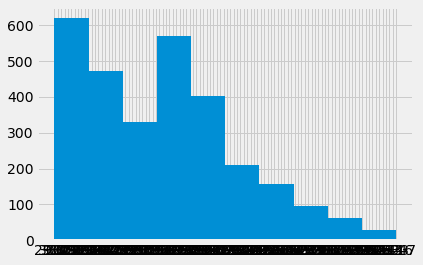

In [117]:
plt.hist(weather['sealevel'])

In [118]:
weather['sealevel'].describe()

count      2944
unique      102
top       30.00
freq         96
Name: sealevel, dtype: object

In [119]:
count = 0
for i in weather['sealevel']:
    if i == "M":
        count += 1
print(count)

9


In [120]:
weather.reset_index(inplace = True)

In [121]:
weather[weather['sealevel'] =="M"]

,level_0,index,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
416,416,416,1,2009-06-18,80,61,71,1,63,67,...,0.12,29.08,M,6.7,16,7.9,2009,6,25,3
497,497,497,1,2009-09-07,77,59,68,1,59,62,...,0.00,29.39,M,5.8,3,4.0,2009,9,37,0
866,866,866,1,2011-09-08,75,57,66,0,53,59,...,0.00,29.34,M,13.0,2,13.4,2011,9,36,3
878,878,878,1,2011-09-20,74,49,62,0,54,58,...,0.00,29.26,M,7.3,18,7.3,2011,9,38,1
1045,1045,1045,1,2012-09-03,88,71,80,12,70,73,...,0.00,29.17,M,4.6,6,4.4,2012,9,36,0
1515,1515,43,2,2007-06-13,86,68,77,9,53,62,...,0.00,29.36,M,7.0,5,M,2007,6,24,2
2344,2344,872,2,2011-09-14,60,48,54,-10,45,51,...,0.00,29.47,M,6.0,32,M,2011,9,37,2
2505,2505,1033,2,2012-08-22,84,72,78,7,51,61,...,0.00,29.39,M,4.7,19,M,2012,8,34,2
2843,2843,1371,2,2014-07-23,76,64,70,-4,56,61,...,0.00,29.47,M,16.4,2,16.7,2014,7,30,2


In [122]:
weather[weather['date'] == "2009-06-18"]

,level_0,index,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
416,416,416,1,2009-06-18,80,61,71,1,63,67,...,0.12,29.08,M,6.7,16,7.9,2009,6,25,3
1888,1888,416,2,2009-06-18,81,63,72,2,64,67,...,0.11,29.15,29.79,3.7,17,5.8,2009,6,25,3


In [123]:
weather.iloc[416,-8] = 29.79

In [124]:
weather[weather['date'] == "2009-09-07"]

,level_0,index,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
497,497,497,1,2009-09-07,77,59,68,1,59,62,...,0.00,29.39,M,5.8,3,4.0,2009,9,37,0
1969,1969,497,2,2009-09-07,77,63,70,3,59,63,...,0.00,29.44,30.09,6.3,4,6.9,2009,9,37,0


In [125]:
weather.iloc[497,-8] = 30.09

In [126]:
weather[weather['date'] == "2011-09-08"]

,level_0,index,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
866,866,866,1,2011-09-08,75,57,66,0,53,59,...,0.00,29.34,M,13.0,2,13.4,2011,9,36,3
2338,2338,866,2,2011-09-08,74,62,68,2,54,59,...,0.06,29.36,30.03,14.9,2,15.2,2011,9,36,3


In [127]:
weather.iloc[866,-8] = 30.03

In [128]:
weather[weather['date'] == "2011-09-20"]

,level_0,index,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
878,878,878,1,2011-09-20,74,49,62,0,54,58,...,0.00,29.26,M,7.3,18,7.3,2011,9,38,1
2350,2350,878,2,2011-09-20,75,53,64,2,54,58,...,0.01,29.33,29.99,5.8,17,6.1,2011,9,38,1


In [129]:
weather.iloc[878,-8] = 29.99

In [130]:
weather[weather['date'] == "2012-09-03"]

,level_0,index,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
1045,1045,1045,1,2012-09-03,88,71,80,12,70,73,...,0.00,29.17,M,4.6,6,4.4,2012,9,36,0
2517,2517,1045,2,2012-09-03,87,73,80,12,69,73,...,0.00,29.23,29.87,5.0,7,5.9,2012,9,36,0


In [131]:
weather.iloc[1045,-8] = 29.87

In [132]:
#problem
weather[weather['date'] == "2007-06-13"]

,level_0,index,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
43,43,43,1,2007-06-13,87,60,74,6,53,62,...,0.00,29.36,30.09,7.2,5,8.6,2007,6,24,2
1515,1515,43,2,2007-06-13,86,68,77,9,53,62,...,0.00,29.36,M,7.0,5,M,2007,6,24,2


In [133]:
weather.iloc[1515,-8] = 30.09

In [134]:
weather[weather['date'] == "2011-09-14"]

,level_0,index,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
872,872,872,1,2011-09-14,58,47,53,-11,43,49,...,0.08,29.39,30.09,6.3,34,7.3,2011,9,37,2
2344,2344,872,2,2011-09-14,60,48,54,-10,45,51,...,0.00,29.47,M,6.0,32,M,2011,9,37,2


In [135]:
weather.iloc[2344,-8] = 30.09

In [136]:
weather[weather['date'] == "2012-08-22"]

,level_0,index,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
1033,1033,1033,1,2012-08-22,85,54,70,-1,52,60,...,0.00,29.35,30.07,5.5,19,5.8,2012,8,34,2
2505,2505,1033,2,2012-08-22,84,72,78,7,51,61,...,0.00,29.39,M,4.7,19,M,2012,8,34,2


In [137]:
weather.iloc[2505,-8] = 30.07

In [138]:
weather[weather['date'] == "2014-07-23"]

,level_0,index,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
1371,1371,1371,1,2014-07-23,75,59,67,-7,51,58,...,0.00,29.41,30.12,15.7,2,16.1,2014,7,30,2
2843,2843,1371,2,2014-07-23,76,64,70,-4,56,61,...,0.00,29.47,M,16.4,2,16.7,2014,7,30,2


In [139]:
weather.iloc[2843,-8] = 30.12

In [140]:
count = 0
for i in weather['sealevel']:
    if i == "M":
        count += 1
print(count)

0


In [141]:
weather.sealevel = weather.sealevel.astype('float')

### ResultSpeed

(array([244., 663., 800., 611., 367., 170.,  57.,  18.,   9.,   5.]),
 array([ 0.1,  2.5,  4.9,  7.3,  9.7, 12.1, 14.5, 16.9, 19.3, 21.7, 24.1]),
 <BarContainer object of 10 artists>)

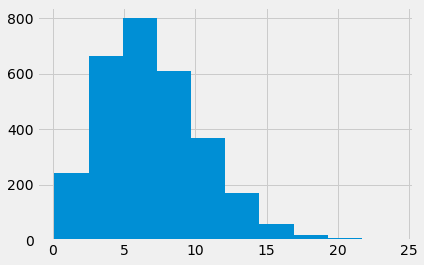

In [142]:
plt.hist(weather['resultspeed'])

In [143]:
weather['resultspeed'].describe()

count    2944.000000
mean        6.960666
std         3.587527
min         0.100000
25%         4.300000
50%         6.400000
75%         9.200000
max        24.100000
Name: resultspeed, dtype: float64

### ResultDir

(array([432., 322., 235., 137., 234., 412., 482., 255., 243., 192.]),
 array([ 1. ,  4.5,  8. , 11.5, 15. , 18.5, 22. , 25.5, 29. , 32.5, 36. ]),
 <BarContainer object of 10 artists>)

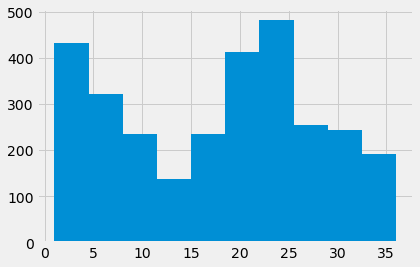

In [144]:
plt.hist(weather['resultdir'])

In [145]:
weather['resultdir'].describe()

count    2944.000000
mean       17.494905
std        10.063609
min         1.000000
25%         7.000000
50%        19.000000
75%        25.000000
max        36.000000
Name: resultdir, dtype: float64

### AvgSpeed

In [146]:
weather['avgspeed'].describe()

count     2944
unique     178
top        6.9
freq        63
Name: avgspeed, dtype: object

In [147]:
count = 0
for i in weather['avgspeed']:
    if i == "M":
        count += 1
print(count)

3


There are 4 counts of "avgspeed" being "M".

In [148]:
weather[weather['avgspeed']=="M"]

,level_0,index,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
1515,1515,43,2,2007-06-13,86,68,77,9,53,62,...,0.00,29.36,30.09,7.0,5,M,2007,6,24,2
2344,2344,872,2,2011-09-14,60,48,54,-10,45,51,...,0.00,29.47,30.09,6.0,32,M,2011,9,37,2
2505,2505,1033,2,2012-08-22,84,72,78,7,51,61,...,0.00,29.39,30.07,4.7,19,M,2012,8,34,2


In [149]:
weather[weather['date'] == "2007-06-13"]

,level_0,index,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
43,43,43,1,2007-06-13,87,60,74,6,53,62,...,0.00,29.36,30.09,7.2,5,8.6,2007,6,24,2
1515,1515,43,2,2007-06-13,86,68,77,9,53,62,...,0.00,29.36,30.09,7.0,5,M,2007,6,24,2


In [150]:
weather.iloc[1515,-5] = 8.6

In [151]:
weather[weather['date'] == "2011-09-14"]

,level_0,index,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
872,872,872,1,2011-09-14,58,47,53,-11,43,49,...,0.08,29.39,30.09,6.3,34,7.3,2011,9,37,2
2344,2344,872,2,2011-09-14,60,48,54,-10,45,51,...,0.00,29.47,30.09,6.0,32,M,2011,9,37,2


In [152]:
weather.iloc[2344,-5] = 7.3

In [153]:
weather[weather['date'] == "2012-08-22"]

,level_0,index,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek
1033,1033,1033,1,2012-08-22,85,54,70,-1,52,60,...,0.00,29.35,30.07,5.5,19,5.8,2012,8,34,2
2505,2505,1033,2,2012-08-22,84,72,78,7,51,61,...,0.00,29.39,30.07,4.7,19,M,2012,8,34,2


In [154]:
weather.iloc[2505,-5] = 5.8

In [155]:
weather.avgspeed.value_counts()

6.9     63
5.8     60
7.4     55
8.1     49
7.0     47
        ..
16.2     1
16.9     1
18.8     1
23.2     1
22.6     1
Name: avgspeed, Length: 180, dtype: int64

In [156]:
weather.avgspeed = weather.avgspeed.astype('float')

(array([113., 761., 926., 675., 293., 122.,  38.,   7.,   8.,   1.]),
 array([ 1.7 ,  4.16,  6.62,  9.08, 11.54, 14.  , 16.46, 18.92, 21.38,
        23.84, 26.3 ]),
 <BarContainer object of 10 artists>)

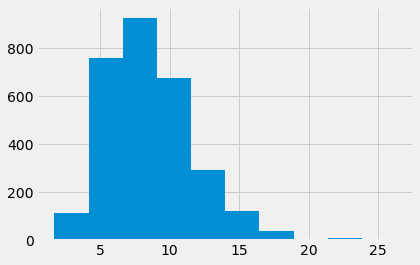

In [157]:
plt.hist(weather['avgspeed'])

In [158]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   level_0      2944 non-null   int64         
 1   index        2944 non-null   int64         
 2   station      2944 non-null   int64         
 3   date         2944 non-null   datetime64[ns]
 4   tmax         2944 non-null   int64         
 5   tmin         2944 non-null   int64         
 6   tavg         2944 non-null   int64         
 7   depart       2944 non-null   int64         
 8   dewpoint     2944 non-null   int64         
 9   wetbulb      2944 non-null   int64         
 10  heat         2944 non-null   int64         
 11  cool         2944 non-null   int64         
 12  sunrise      2944 non-null   int64         
 13  sunset       2944 non-null   int64         
 14  codesum      2944 non-null   object        
 15  preciptotal  2944 non-null   object        
 16  stnpre

## Joining traintest and weather dataframes

In [159]:
weather.drop(columns=["index"],inplace = True)

In [160]:
# create 2 columns to show the distance of each trap to weather station1 and station2
# Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
traintest['dist_s1'] = traintest.apply(
    lambda row: ((row['latitude'] - 41.995)**2 + (row['longitude'] - (-87.9336))**2)**0.5,
    axis = 1
)

# Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level
traintest['dist_s2'] = traintest.apply(
    lambda row: ((row['latitude'] - 41.78611)**2 + (row['longitude'] - (-87.75222))**2)**0.5,
    axis = 1
)


In [161]:
# create a column to indicate the nearest weather station - 1 or 2 - for each trap
traintest['nearest_stat'] = traintest.apply(
    lambda row: 1 if row['dist_s1'] > row['dist_s2'] else 2,
    axis = 1
)

In [162]:
df = pd.merge(traintest, 
              weather, 
              how='left', 
              left_on= ['date', 'nearest_stat'], 
              right_on = ['date', 'station'] 
             )

In [163]:
spray['date'].value_counts()

2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2011-09-07    2114
2013-07-25    1607
2013-08-22    1587
2013-08-08    1195
2013-09-05     924
2013-08-16     141
2011-08-29      95
Name: date, dtype: int64

In [164]:
# create function to return 1 if trap received spray within 1.1km (0.01 degree of latitude) within the past 7 day
def near_spray(trap_lat, trap_long, date):
    
    """ Input latitude and longitude of trap and date of interest. Return 1 if trap received spray 
    within 1.1km (0.01 degree of latitude) within the past 7 day"""
    
    trap_loc = geometry.Point(trap_lat, trap_long)

    # create your circle buffer from trap_loc
    distance = 0.01
    circle_buffer = trap_loc.buffer(distance)

    for lat, long in zip(list(spray.loc[(spray['date'] <= date) & (spray['date'] >= (date - timedelta(days=7))),'latitude']), list(spray.loc[(spray['date'] <= date) & (spray['date'] >= (date - timedelta(days=7))),'longitude'])):
        spray_loc = geometry.Point(lat, long)

        # and you can then check if the other point lies within
        if spray_loc.within(circle_buffer):
            return 1

In [165]:
# create a column is_spray - 1 if trap received spray within 1.1km (0.01 degree of latitude) within the past 7 day
df['is_spray'] = df.apply(
    lambda row: near_spray(row['latitude'], row['longitude'], row['date']),
    axis = 1
)

In [166]:
# number of traps sprayed within 1.1km (0.01 degree of latitude) within the past 7 days
df.loc[df['is_spray']==1,['date', 'trap', 'is_spray']].groupby('date').sum()

,is_spray
date,
2011-09-12,2.0
2013-07-19,12.0
2013-07-25,1.0
2013-08-01,3.0
2013-08-08,3.0
2013-08-15,13.0
2013-08-22,22.0
2013-08-29,14.0
2013-09-06,2.0


In [167]:
df['is_spray'].fillna(0, inplace=True)

In [168]:
df.describe()

,latitude,longitude,wnvpresent,year_x,month_x,week_x,dayofweek_x,nummosquitos,dist_s1,dist_s2,...,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year_y,month_y,week_y,dayofweek_y,is_spray
count,51339.000000,51339.000000,8304.000000,51339.000000,51339.000000,51339.000000,51339.000000,8304.000000,51339.000000,51339.000000,...,51339.000000,51339.000000,51339.000000,51339.000000,51339.000000,51339.000000,51339.000000,51339.000000,51339.000000,51339.000000
mean,41.847897,-87.692842,0.055034,2010.540681,7.634118,31.473753,2.610803,16.095255,0.291994,0.146752,...,29.277861,29.980454,6.318633,18.147919,7.923951,2010.540681,7.634118,31.473753,2.610803,0.001441
std,0.106425,0.080191,0.228060,2.192727,1.074400,4.677302,1.413362,69.585928,0.110001,0.059698,...,0.121218,0.122594,2.857758,10.142124,2.587857,2.192727,1.074400,4.677302,1.413362,0.037939
min,41.644612,-87.930995,0.000000,2007.000000,5.000000,22.000000,0.000000,1.000000,0.037292,0.007815,...,28.890000,29.590000,0.100000,1.000000,1.900000,2007.000000,5.000000,22.000000,0.000000,0.000000
25%,41.753391,-87.749149,0.000000,2008.000000,7.000000,28.000000,1.000000,2.000000,0.205361,0.110599,...,29.180000,29.890000,4.200000,8.000000,6.100000,2008.000000,7.000000,28.000000,1.000000,0.000000
50%,41.857402,-87.694259,0.000000,2010.000000,8.000000,31.000000,3.000000,4.000000,0.285037,0.151888,...,29.280000,29.980000,6.000000,19.000000,7.800000,2010.000000,8.000000,31.000000,3.000000,0.000000
75%,41.948280,-87.648064,0.000000,2012.000000,8.000000,35.000000,4.000000,12.000000,0.380360,0.190375,...,29.360000,30.070000,8.000000,26.000000,9.600000,2012.000000,8.000000,35.000000,4.000000,0.000000
max,42.017430,-87.531635,1.000000,2014.000000,10.000000,41.000000,4.000000,2206.000000,0.522874,0.250867,...,29.650000,30.330000,16.600000,36.000000,17.300000,2014.000000,10.000000,41.000000,4.000000,1.000000


In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51339 entries, 0 to 51338
Data columns (total 39 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   dataset       51339 non-null  object        
 1   date          51339 non-null  datetime64[ns]
 2   species       51339 non-null  object        
 3   trap          51339 non-null  object        
 4   latitude      51339 non-null  float64       
 5   longitude     51339 non-null  float64       
 6   wnvpresent    8304 non-null   float64       
 7   year_x        51339 non-null  int64         
 8   month_x       51339 non-null  int64         
 9   week_x        51339 non-null  int64         
 10  dayofweek_x   51339 non-null  int64         
 11  nummosquitos  8304 non-null   float64       
 12  dist_s1       51339 non-null  float64       
 13  dist_s2       51339 non-null  float64       
 14  nearest_stat  51339 non-null  int64         
 15  level_0       51339 non-null  int64 

### Export CSV

In [170]:
df.to_csv('../data/combined.csv')

In [171]:
weather.to_csv('../data/processed_weather.csv')